# Clean the text

In [1]:
from __future__ import division

import re
import string
import cPickle
import unicodedata
import numpy as np
import pandas as pd

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from gensim.models import KeyedVectors

## Read, clean and tokenise the data

Read in the pickled text and put into a dataframe.

In [2]:
fin_name = './questions.pkl'

with open(fin_name, 'r') as f_in:
    text = cPickle.load(f_in)

df = pd.DataFrame()
df['text'] = text
df.head()

,text
0,"To ask Mr Chancellor of the Exchequer, whether..."
1,"To ask Mr Chancellor of the Exchequer, how man..."
2,To ask Her Majesty's Government whether an Eng...
3,"To ask Mr Chancellor of the Exchequer, how man..."
4,"To ask Mr Chancellor of the Exchequer, when he..."


Define a list of project specific stopwords.

In [3]:
# Stop words defined before stemming
my_stopwords = [
                    'mr', 
                    'ask', 
                    'chancellor', 
                    'exchequer',
                    'government',
                    'tax',
                    'department',
                    'assessment',
                    'hm',
                    'revenue',
                    'custom',
                    'make',
                    'take',
                    'majesty',
                    'majestys',
                    'many',
                    'year',
                    'plan',
                    'question',
                    'answer',
                    'financial',
                    'statement',
                    'uk',
                    'whether',
                    'since'
                ]

Define functions to lemmatise words (from ren-hoek).

In [4]:
def get_wordnet_pos(t):
    
    """Convert treeback POS tag.


    Converts the tressbank pos tag to wordnet to use
    with the Wordnet lemmatizer

    Input:
        t: treebank pos tag

    Output
        d: wordnet pos tag

    """

    if t.startswith('J'):
        return wordnet.ADJ
    elif t.startswith('V'):
        return wordnet.VERB
    elif t.startswith('N'):
        return wordnet.NOUN
    elif t.startswith('R'):
        return wordnet.ADV
    else:
        return ""


def lemmatize(w, p):

    """Lemmatize word using wordnet.


    Input:
        w: unlemmatized word
        p: pos tag

    Output
        d: lemmatized word

    """

    if p != "":
        return WordNetLemmatizer().lemmatize(w, p)
    else:
        return WordNetLemmatizer().lemmatize(w, wordnet.NOUN) 

Define a function to clean and tokenise the results.

In [5]:
def tokeniser(text):
    
    # Remove any whitespace at the start and end of the string
    # and remove any stray tabs and newline characters
    text = text.strip()
    
    # Remove any weird unicode characters
    if isinstance(text, unicode):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')
        
    # Convert hyphens and slashes to spaces
    text = re.sub(r'[-/]+',' ',text)
    
    # Remove remaining punctuation
    text = text.translate(None, string.punctuation)
    
    # Convert the text to lowercase and use nltk tokeniser
    tokens = pos_tag(word_tokenize(text.lower()))
    
    # Lemmatize
    tokens = [lemmatize(x[0], get_wordnet_pos(x[1])) for x in tokens]
    
    # Define a list of stopwords apart from the word 'not'
    stops = set(stopwords.words('english') + my_stopwords) - set(('not'))


    return [i for i in tokens if i not in stops]


Apply this function.

In [6]:
df['tokens'] = df['text'].apply(tokeniser)
df.head()

,text,tokens
0,"To ask Mr Chancellor of the Exchequer, whether...","[rate, corporation, pay, private, sector, cont..."
1,"To ask Mr Chancellor of the Exchequer, how man...","[credit, union, subject, intervention, service..."
2,To ask Her Majesty's Government whether an Eng...,"[english, couple, marry, humanist, ceremony, s..."
3,"To ask Mr Chancellor of the Exchequer, how man...","[proportion, write, parliamentary, 2017, 18, s..."
4,"To ask Mr Chancellor of the Exchequer, when he...","[publish, data, exception, two, child, credit,..."


## Quick check

Word clouds are a good check that no stop words have been missed.

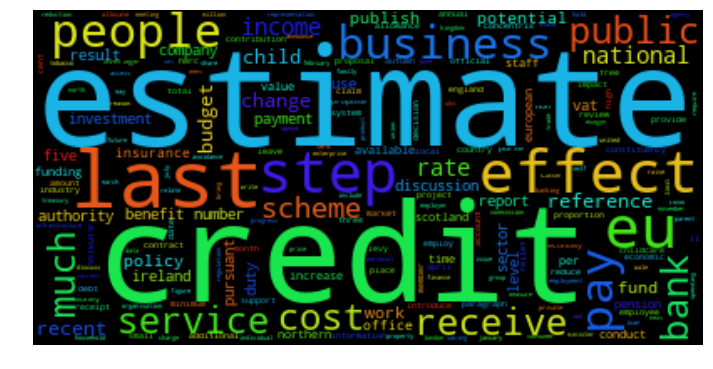

In [7]:
# Combined the tokens back into whole strings
cleaned_strings = df['tokens'].apply(lambda x: ' '.join(x)).tolist()

# Join the strings together
combined_text = ' '.join(cleaned_strings)

# Display a word cloud
wc = WordCloud(random_state=42).generate( combined_text )
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Create document vectors

A quick way of creating document vectors is to aggregate pre-trained word2vec embeddings (where each word vector is multiplied by its inverse document frequency).

Here, a cut down version of the Google news vectors is used as it is a much smaller download. This is obtained from:

https://github.com/eyaler/word2vec-slim


So first read this data in.

In [8]:
f_word2vec = './GoogleNews-vectors-negative300-SLIM.bin'
model = KeyedVectors.load_word2vec_format(f_word2vec, binary=True) 

Next define functions to calculate the document vectors. This starts by pre-processing the vectors in the exact same way as those contained in the pretrained model, then the inverse document frequencies are calculated, and finally the weighted word vectors are summed and normalised. 

According to this discussion:

https://groups.google.com/forum/#!topic/word2vec-toolkit/TI-TQC-b53w

this involves removing all punctutation, removing multiple whitespace, converting to lowercase and converting decimals to words. 

In [9]:
def word2vec_preprocess(text):
    ''' Preprocess text in the same way as in the pretrained model.'''
    
    # Remove any whitespace at the start and end of the string
    # and remove any stray tabs and newline characters
    text = text.strip()
    
    # Remove any weird unicode characters
    if isinstance(text, unicode):
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore')
        
    # Convert hyphens and slashes to spaces
    text = re.sub(r'[-/]+',' ',text)
    
    # Remove remaining punctuation
    text = text.translate(None, string.punctuation)
    
    # Convert numbers to text
    text = re.sub(r'0\s*', 'zero ', text)
    text = re.sub(r'1\s*', 'one ', text)
    text = re.sub(r'2\s*', 'two ', text)
    text = re.sub(r'3\s*', 'three ', text)
    text = re.sub(r'4\s*', 'four ', text)
    text = re.sub(r'5\s*', 'five ', text)
    text = re.sub(r'6\s*', 'six ', text)
    text = re.sub(r'7\s*', 'seven ', text)
    text = re.sub(r'8\s*', 'eight ', text)
    text = re.sub(r'9\s*', 'nine ', text)
    
    # Convert the text to lowercase and use nltk tokeniser
    tokens = pos_tag(word_tokenize(text.lower()))
    
    # Lemmatize version and non-lemmatized version
    tokens = [ (lemmatize(x[0], get_wordnet_pos(x[1])), x[0]) for x in tokens]

    # Define a list of stopwords apart from the word 'not'
    stops = set(stopwords.words('english') + my_stopwords) - set(('not'))

    return [i[1] for i in tokens if i[0] not in stops]


def normalise(vec):
    '''Normalise a vector.'''
    
    norm = np.linalg.norm(vec)
    if norm < 1e-9:
        return vec
    else:
        return vec / norm

    
def calc_vector(text, model, idf):
    '''For a given string calcuate the document vector.
    
       Assumes that the words2vec vectors have been normalised.
    '''
    vector = np.zeros(300)
    for word in text:
        if (word in idf) and (word in model):
            vector += idf[word]*model[word]
               
    return normalise(vector)


def calc_idf(df):
    '''Calculate inverse document frequencies.'''

    tfidf = TfidfVectorizer(
            tokenizer = lambda x: x, 
            preprocessor = None, 
            lowercase = False, 
            ngram_range = [1,1]
        )
    
    tfidf.fit(df)
    idf = dict( zip(tfidf.get_feature_names(), tfidf.idf_) )

    return idf


def generate_doc_vecs(df_corpus, model):
    ''' Generate document vectors for each row of a dataframe.'''
    
    df_tokens = df_corpus.apply(word2vec_preprocess)
    
    idf = calc_idf(df_tokens)
    
    df_vectors = df_tokens.apply(lambda x: calc_vector(x, model, idf))
    
    return df_vectors

Apply this function to our data and view the results.

In [10]:
df['doc_vectors'] = generate_doc_vecs(df['text'], model)
df.head()

,text,tokens,doc_vectors
0,"To ask Mr Chancellor of the Exchequer, whether...","[rate, corporation, pay, private, sector, cont...","[-0.0283126130961, 0.0144034179489, 0.03053956..."
1,"To ask Mr Chancellor of the Exchequer, how man...","[credit, union, subject, intervention, service...","[0.0119671818668, 0.00430171885093, -0.0317414..."
2,To ask Her Majesty's Government whether an Eng...,"[english, couple, marry, humanist, ceremony, s...","[0.0293631311379, -0.0421065800222, -0.0725590..."
3,"To ask Mr Chancellor of the Exchequer, how man...","[proportion, write, parliamentary, 2017, 18, s...","[-0.0193267240964, -0.0384130740831, 0.0414060..."
4,"To ask Mr Chancellor of the Exchequer, when he...","[publish, data, exception, two, child, credit,...","[-0.0450472027928, -0.0256289190879, -0.012599..."


## Save the dataframe

In [11]:
fout_name = "./tokenised.pkl"
df.to_pickle(fout_name)